# MMM Example Notebook


**Author:** [Juan Orduz](https://juanitorduz.github.io/)
**Main Reference:** [Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns](https://juanitorduz.github.io/pymc_mmm/)

---
# Part I: Data Generation Process

For this example we use simulated data.

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns

from pymmmc.transformers import geometric_adstock_vectorized, logistic_saturation
from pymmmc.utils import generate_fourier_modes

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "png"

/Users/juanitorduz/opt/anaconda3/envs/pymmmc_env/lib/python3.8/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/Users/juanitorduz/opt/anaconda3/envs/pymmmc_env/lib/python3.8/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Generate Data

See [Media Effect Estimation with Orbit's KTR Model](https://juanitorduz.github.io/orbit_mmm/).

### 1. Date Range

In [2]:
SEED = 42
np.random.seed(SEED)

# date range
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

data_df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = data_df.shape[0]

### 2. Media Costs Data

- Raw Signal

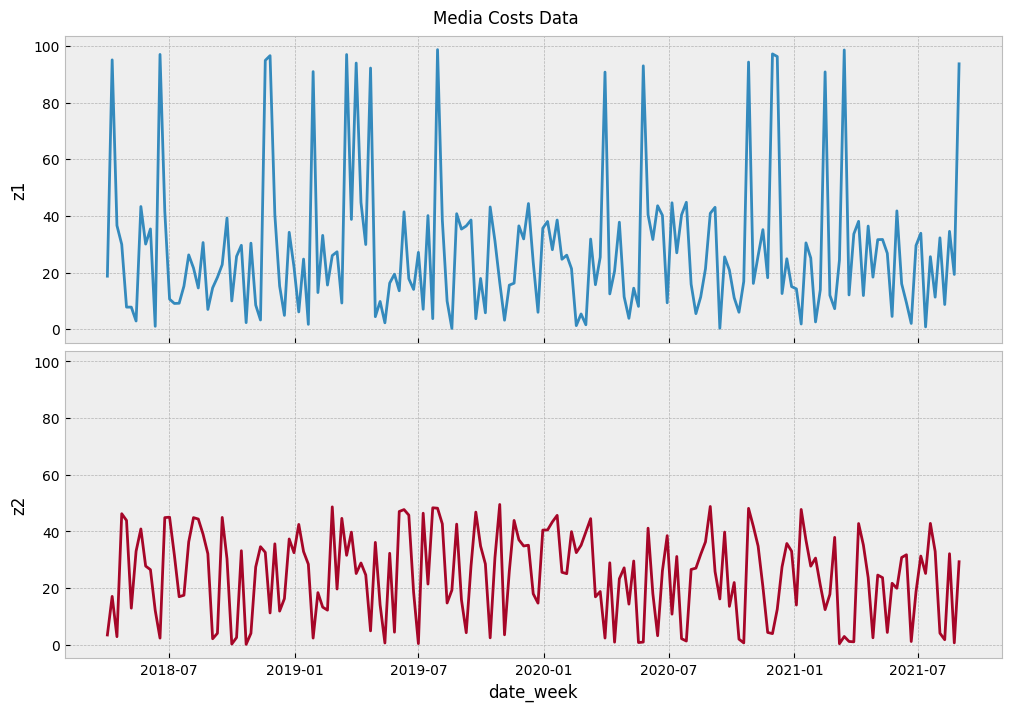

In [3]:
# media data
z1 = np.random.uniform(low=0.0, high=1.0, size=n)
data_df["z1"] = 100 * np.where(z1 > 0.9, z1, z1 / 2)

z2 = np.random.uniform(low=0.0, high=1.0, size=n)
data_df["z2"] = 50 * np.where(z2 > 0.2, z2, z2 / 2)

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date_week", y="z1", data=data_df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="z2", data=data_df, color="C1", ax=ax[1])
fig.suptitle("Media Costs Data");

- Effect Signal

In [4]:
# scale features
data_df["z1_scaled"] = MinMaxScaler().fit_transform(X=data_df[["z1"]])

data_df["z2_scaled"] = MinMaxScaler().fit_transform(X=data_df[["z2"]])

# apply saturation transformation
lam1 = 5
lam2 = 3

data_df["z1_saturated"] = logistic_saturation(
    x=data_df["z1_scaled"].to_numpy(), lam=lam1
).eval()

data_df["z2_saturated"] = logistic_saturation(
    x=data_df["z2_scaled"].to_numpy(), lam=lam2
).eval()

# apply geometric adstock transformation
alpha1 = 0.7
alpha2 = 0.3

data_df["z1_saturated_adstock"] = (
    geometric_adstock_vectorized(
        x=data_df[["z1_saturated"]].to_numpy(), alpha=alpha1, l_max=12, normalize=False
    )
    .eval()
    .flatten()
)

data_df["z2_saturated_adstock"] = (
    geometric_adstock_vectorized(
        x=data_df[["z2_saturated"]].to_numpy(), alpha=alpha2, l_max=12, normalize=False
    )
    .eval()
    .flatten()
)

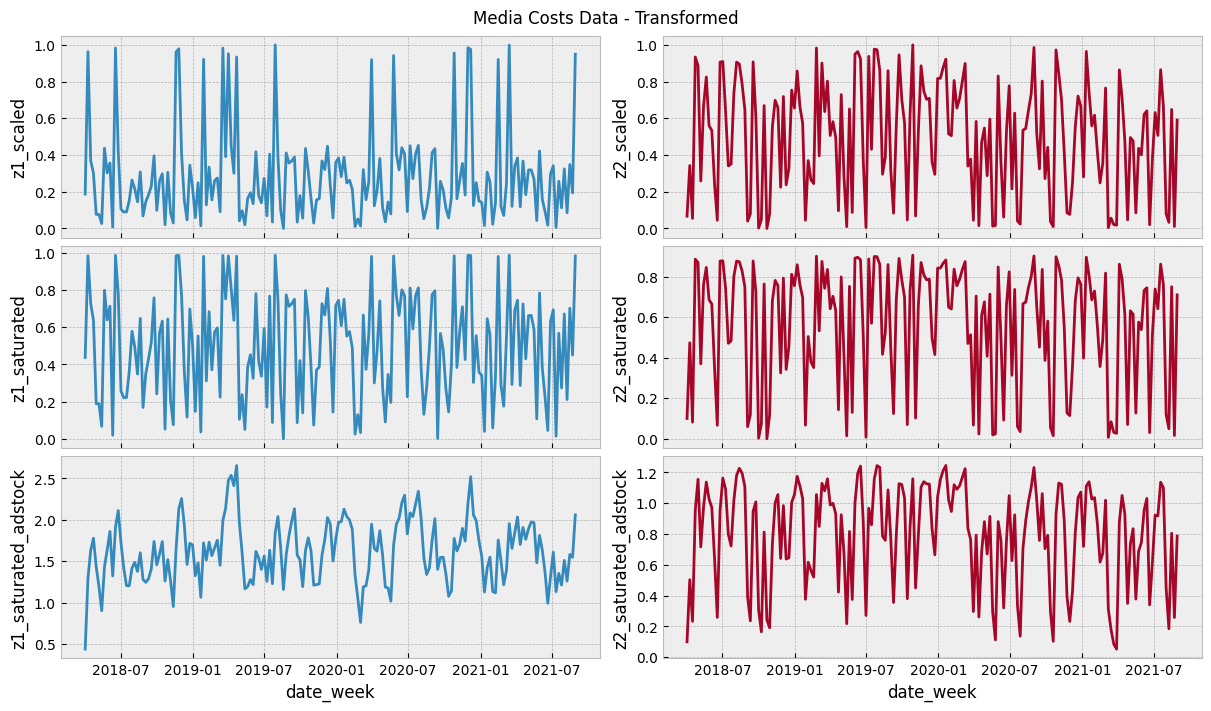

In [5]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="z1_scaled", data=data_df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="z2_scaled", data=data_df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="z1_saturated", data=data_df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="z2_saturated", data=data_df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date_week", y="z1_saturated_adstock", data=data_df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date_week", y="z2_saturated_adstock", data=data_df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed");

### Trend \& Seasonal Components

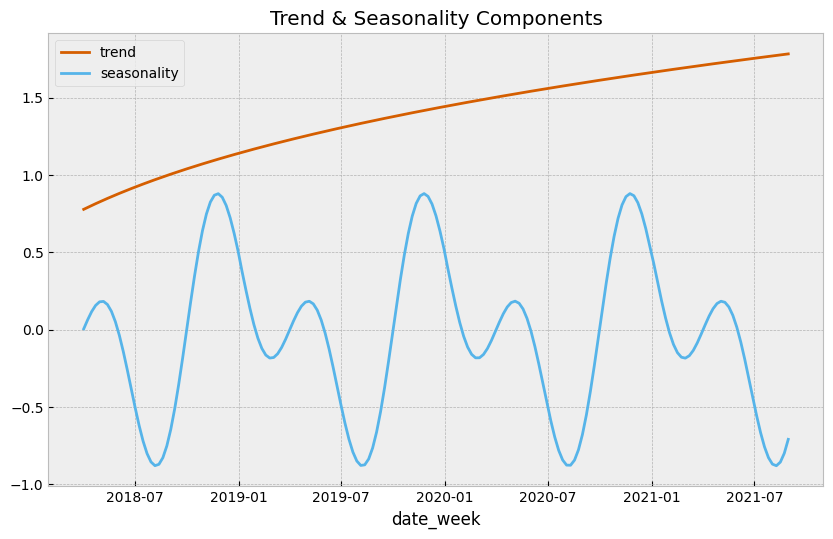

In [6]:
data_df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

data_df["cs"] = - np.sin(2 * 2 * np.pi * data_df["dayofyear"] / 365.5) 
data_df["cc"] = np.cos(1 * 2 * np.pi * data_df["dayofyear"] / 365.5)
data_df["seasonality"] = 0.5 * (data_df["cs"] + data_df["cc"])

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="trend", color="C4", label="trend", data=data_df, ax=ax)
sns.lineplot(x="date_week", y="seasonality", color="C6", label="seasonality", data=data_df, ax=ax)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", ylabel=None);

### Target Variable

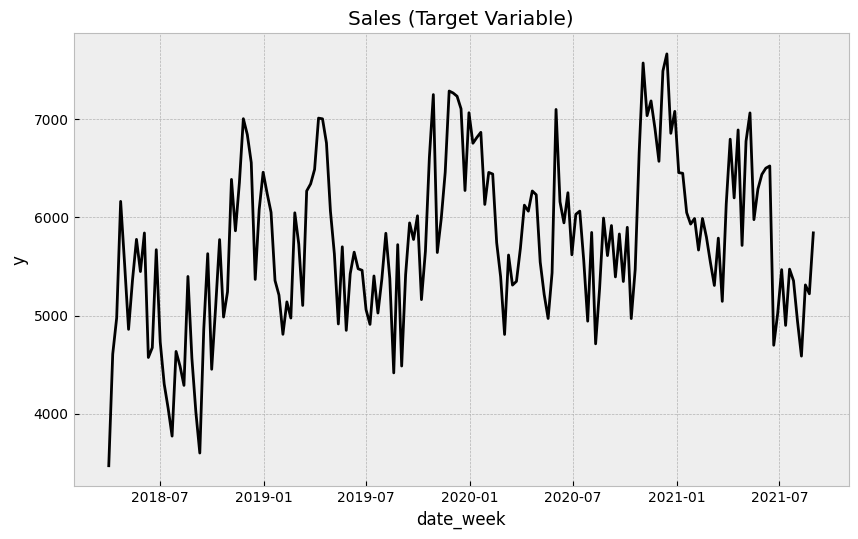

In [7]:
np.random.seed(SEED)

data_df["intercept"] = 2.0
data_df["epsilon"] = np.random.normal(loc=0.0, scale=0.3, size=n)

data_df["y"] = 1_000 * (
    data_df["intercept"]
    + data_df["trend"]
    + data_df["seasonality"]
    + data_df["z1_saturated_adstock"]
    + data_df["z2_saturated_adstock"]
    + data_df["epsilon"]
)

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="y", color="black", data=data_df, ax=ax)
ax.set(title="Sales (Target Variable)");

---

# Part II: Modeling

## 1. Define Model Input

In [8]:
# get features available for modeling
df = data_df[["date_week", "y", "z1", "z2", "dayofyear"]].copy()

# date
date_week = df["date_week"].dt.date.to_numpy()

# target
target = "y"
y = df[target].to_numpy()
n_obs = y.shape[0]

# channels
channels =["z1", "z2"]
channels_df = df[channels].copy()
n_channels = len(channels)

# control variables
df["linear_trend"] = np.linspace(start=0, stop=n, num=n)
control = ["linear_trend"]
control_df = df[control].copy()
n_control = len(control)

features = channels + control

exog_df = df[features]

# Fourier modes
n_order = 3
fourier_features = generate_fourier_modes(
    periods=df["dayofyear"] / 365.25,
    n_order=n_order,
)

## 2. Scale Features

In [9]:
endog_scaler = StandardScaler()
scaled_y = endog_scaler.fit_transform(y.reshape(-1, 1)).ravel()

channels_scaler = MinMaxScaler()
scaled_channels_df = pd.DataFrame(
    data=channels_scaler.fit_transform(X=channels_df), columns=channels_df.columns
)

control_scaler = MinMaxScaler()
scaled_control_df = pd.DataFrame(
    data=control_scaler.fit_transform(X=control_df), columns=control_df.columns
)

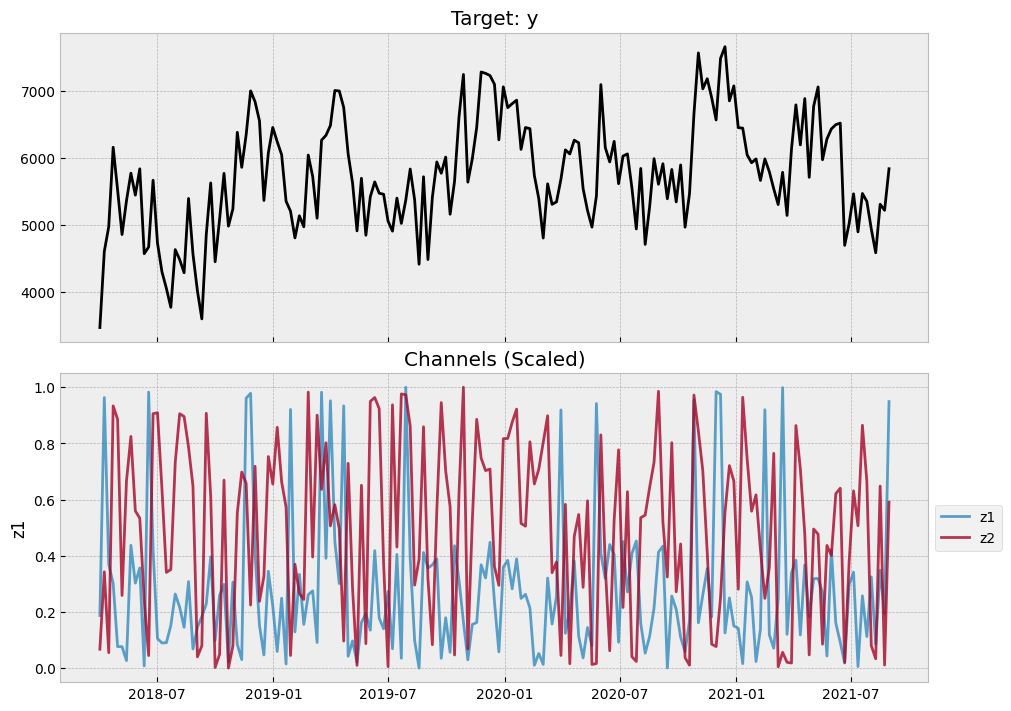

In [10]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 7),
    sharex=True,
    sharey=False,
    layout="constrained",
)

sns.lineplot(x=date_week, y=y, color="black", ax=ax[0])

for i, channel in enumerate(channels):
    sns.lineplot(
        x=date_week,
        y=scaled_channels_df[channel],
        color=f"C{i}",
        alpha=0.8,
        label=f"{channel}",
        ax=ax[1],
    )
ax[0].set(title=f"Target: {target}")
ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].set(title="Channels (Scaled)");

### 3. Model Specification

In [11]:
# define model coordinates
coords = {
    "date_week": date_week,
    "channel": channels,
    "control": control,
    "fourier_mode": fourier_features.columns.to_numpy(),
}

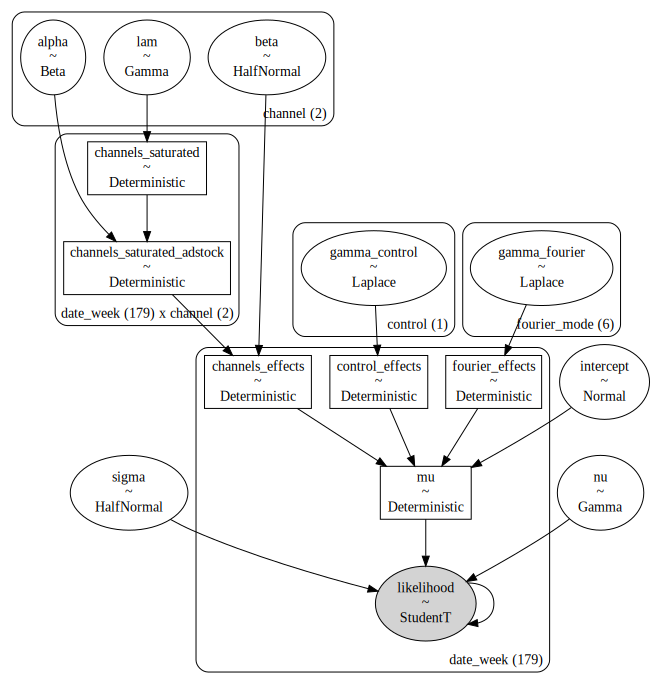

In [12]:
with pm.Model(coords=coords) as model:
    # --- Priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=2)
    # coefficients marketing channels
    beta = pm.HalfNormal(name="beta", sigma=2, dims="channel")
    # adstock parameter
    alpha = pm.Beta(name="alpha", alpha=1, beta=3, dims="channel")
    # saturation parameter
    lam = pm.Gamma(name="lam", alpha=3, beta=1, dims="channel")
    # coefficients control variables
    gamma_control = pm.Laplace(name="gamma_control", mu=0, b=1, dims="control")
    # coefficients fourier modes
    gamma_fourier = pm.Laplace(name="gamma_fourier", mu=0, b=1, dims="fourier_mode")
    # likelihood standard deviation
    sigma = pm.HalfNormal(name="sigma", sigma=2)
    # degrees of freedom
    nu = pm.Gamma(name="nu", alpha=25, beta=2)

    # --- Model Parametrization ---
    # marketing channel effects
    ## saturated-adstock
    channels_saturated = pm.Deterministic(
        name="channels_saturated",
        var=logistic_saturation(x=scaled_channels_df.to_numpy(), lam=lam),
        dims=("date_week", "channel"),
    )
    channels_saturated_adstock = pm.Deterministic(
        name="channels_saturated_adstock",
        var=geometric_adstock_vectorized(
            x=channels_saturated,
            alpha=alpha,
            l_max=12,
            normalize=True,
        ),
        dims=("date_week", "channel"),
    )
    channels_effects = pm.Deterministic(
        name="channels_effects",
        var=pm.math.dot(channels_saturated_adstock, beta),
        dims=("date_week"),
    )
    # control variables effect
    control_effects = pm.Deterministic(
        name="control_effects",
        var=pm.math.dot(scaled_control_df.to_numpy(), gamma_control),
        dims="date_week",
    )
    # fourier modes effect
    fourier_effects = pm.Deterministic(
        name="fourier_effects",
        var=pm.math.dot(fourier_features.to_numpy(), gamma_fourier),
        dims="date_week",
    )

    mu = pm.Deterministic(
        name="mu",
        var=intercept + channels_effects + control_effects + fourier_effects,
        dims="date_week",
    )

    # --- Likelihood ---
    likelihood = pm.StudentT(
        "likelihood", mu=mu, nu=nu, sigma=sigma, dims="date_week", observed=scaled_y
    )

pm.model_to_graphviz(model)

### 4. Prior Predictive Checks

In [13]:
with model:
    prior_predictive = pm.sample_prior_predictive(samples=1000)

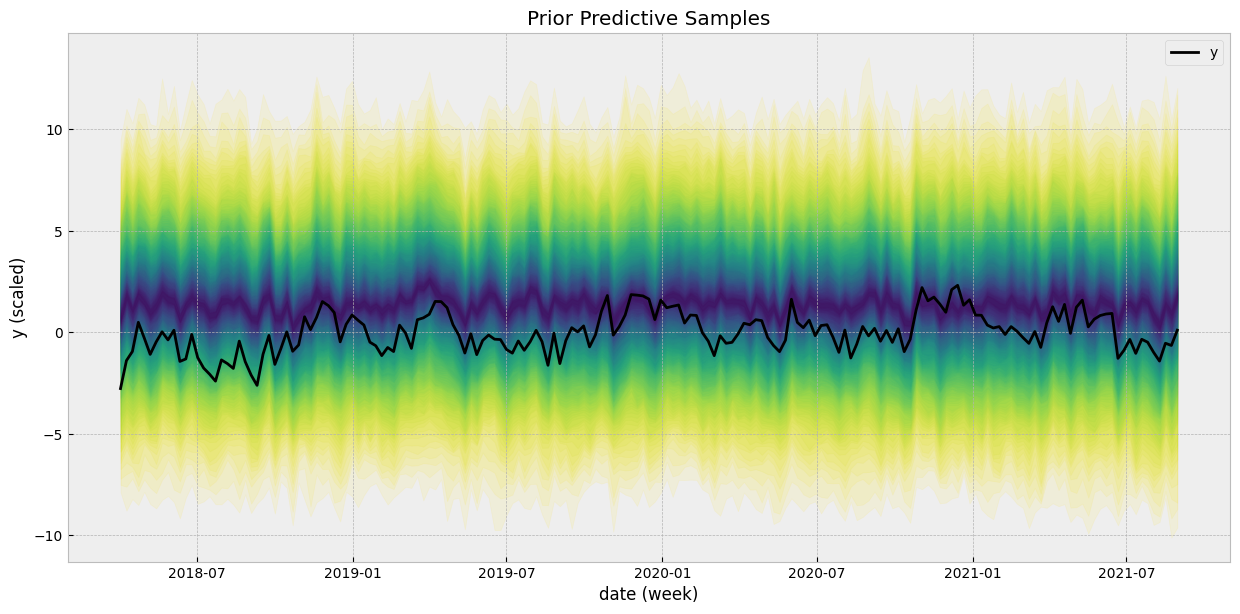

In [14]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(prior_predictive.prior_predictive["likelihood"], p, axis=1)
    lower = np.percentile(
        prior_predictive.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date_week,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(x=date_week, y=scaled_y, label=target, color="black", ax=ax)
ax.set(
    title="Prior Predictive Samples",
    xlabel="date (week)",
    ylabel=f"{target} (scaled)",
);

### 5. Fit Model

In [15]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(
        target_accept=0.95, draws=6000, chains=4
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata)


Compiling...
Compilation time =  0:00:07.985154
Sampling...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Sampling time =  0:00:19.576563
Transforming variables...
Transformation time =  0:00:03.335184


2022-06-17 16:38:25.969398: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:61] Constant folding an instruction is taking > 1s:

  %reduce.7 = f64[4,6000,179]{2,1,0} reduce(f64[4,6000,179,1]{3,2,1,0} %broadcast.11, f64[] %constant.9), dimensions={3}, to_apply=%region_4.374, metadata={op_name="jit(jax_funcified_fgraph)/jit(main)/reduce_prod[axes=(3,)]" source_file="/Users/juanitorduz/opt/anaconda3/envs/pymmmc_env/lib/python3.8/site-packages/aesara/link/jax/dispatch.py" source_line=173}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


### 6. Model Diagnostics

In [16]:
model_var_names = [
    "intercept",
    "beta",
    "alpha",
    "lam",
    "gamma_control",
    "gamma_fourier",
    "sigma",
    "nu",
]

In [17]:
az.summary(data=idata, var_names=model_var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-3.546,0.184,-3.888,-3.196,0.002,0.001,14771.0,16667.0,1.0
beta[z1],4.067,0.312,3.475,4.643,0.003,0.002,13742.0,15703.0,1.0
beta[z2],1.616,0.308,1.141,2.159,0.003,0.002,12710.0,9471.0,1.0
alpha[z1],0.694,0.026,0.645,0.741,0.000,0.000,14419.0,16246.0,1.0
alpha[z2],0.227,0.073,0.092,0.365,0.001,0.000,20201.0,11593.0,1.0
lam[z1],5.726,0.629,4.540,6.895,0.004,0.003,19798.0,17122.0,1.0
lam[z2],2.809,0.715,1.474,4.170,0.006,0.004,14843.0,8975.0,1.0
gamma_control[linear_trend],1.212,0.097,1.028,1.392,0.001,0.000,21446.0,18388.0,1.0
gamma_fourier[sin_order_1],0.036,0.038,-0.037,0.106,0.000,0.000,28291.0,18465.0,1.0
gamma_fourier[cos_order_1],0.589,0.037,0.519,0.659,0.000,0.000,28417.0,18313.0,1.0


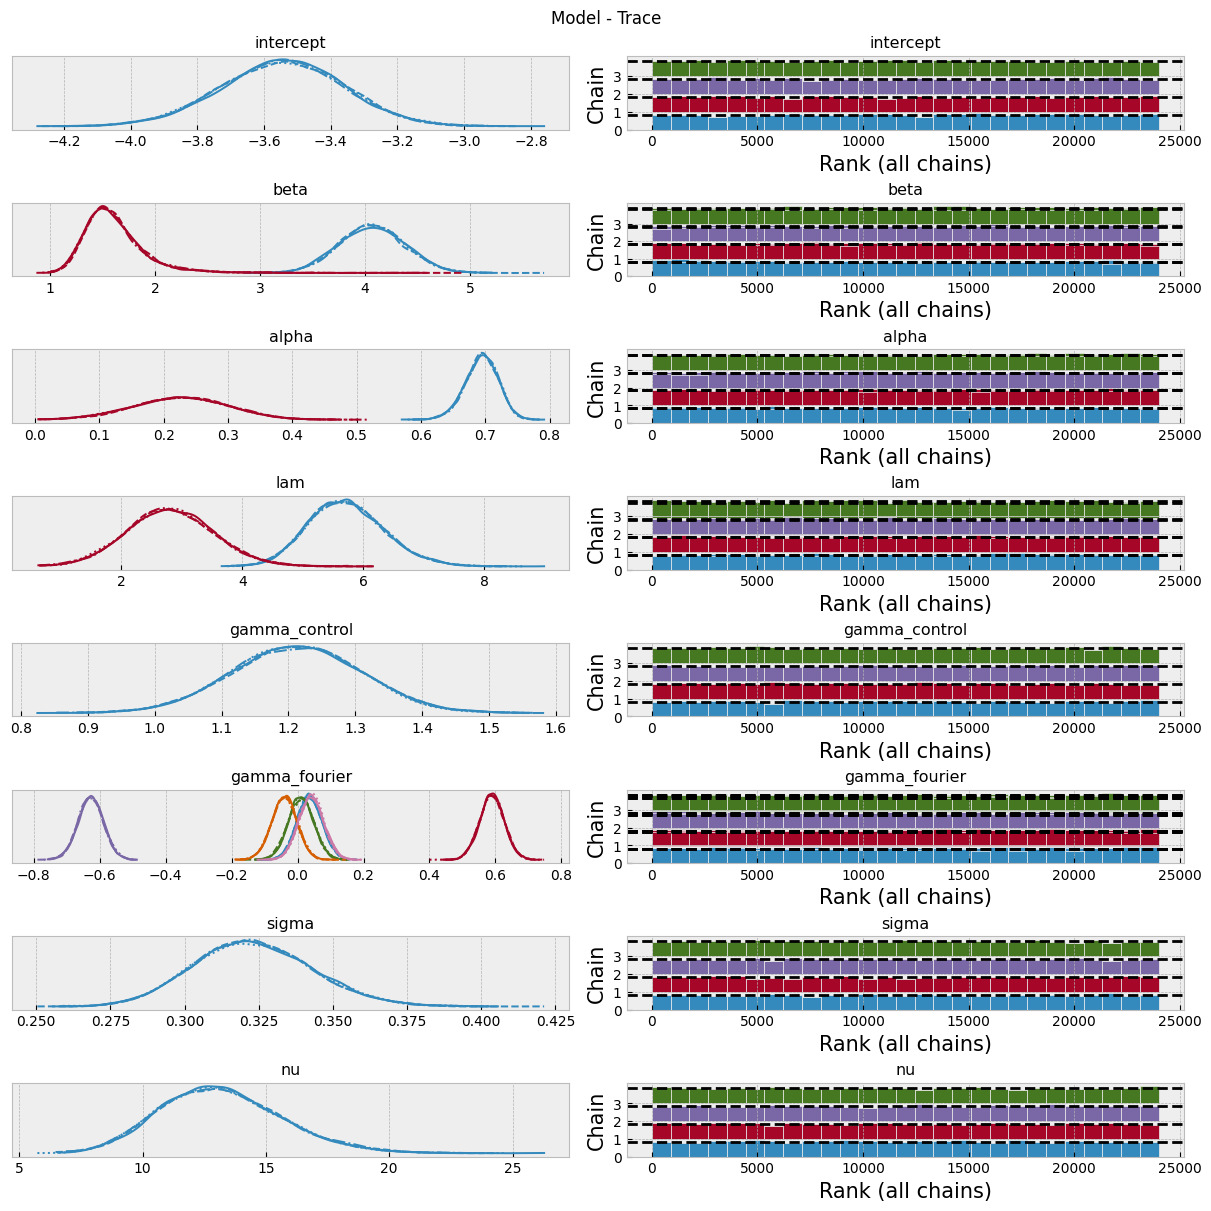

In [18]:
axes = az.plot_trace(
    data=idata,
    var_names=model_var_names,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 12), "layout": "constrained"},
)
plt.gcf().suptitle("Model - Trace");

Text(0.5, 1.05, 'Model - Posterior Distributions - Channels')

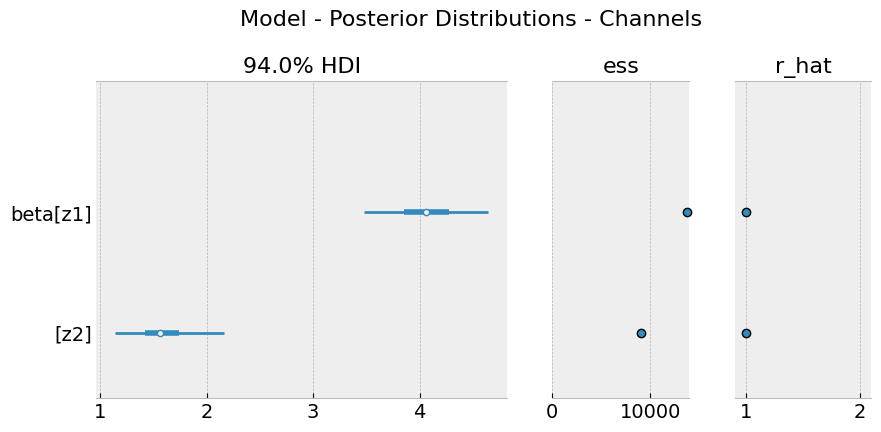

In [19]:
ax = az.plot_forest(
    data=idata,
    var_names=["beta"],
    combined=True,
    r_hat=True,
    ess=True,
)
plt.gcf().suptitle(
    "Model - Posterior Distributions - Channels", fontsize=16, y=1.05
)

### 7. Posterior Predictive

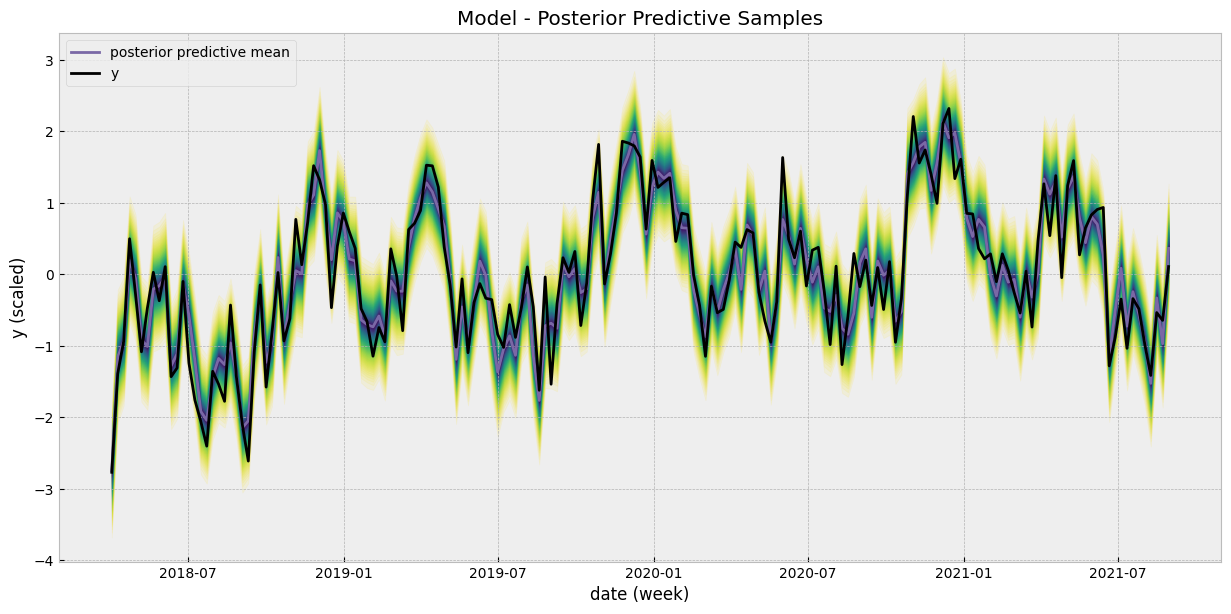

In [20]:
palette = "viridis_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


posterior_predictive_likelihood = posterior_predictive.posterior_predictive[
    "likelihood"
].stack(sample=("chain", "draw"))

fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date_week,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date_week,
    y=posterior_predictive_likelihood.mean(axis=1),
    color="C2",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date_week,
    y=scaled_y,
    color="black",
    label=target,
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(
    title="Model - Posterior Predictive Samples",
    xlabel="date (week)",
    ylabel=f"{target} (scaled)",
);

### 8. Model Components

In [21]:
# compute HDI for all the model parameters
model_hdi = az.hdi(ary=idata)

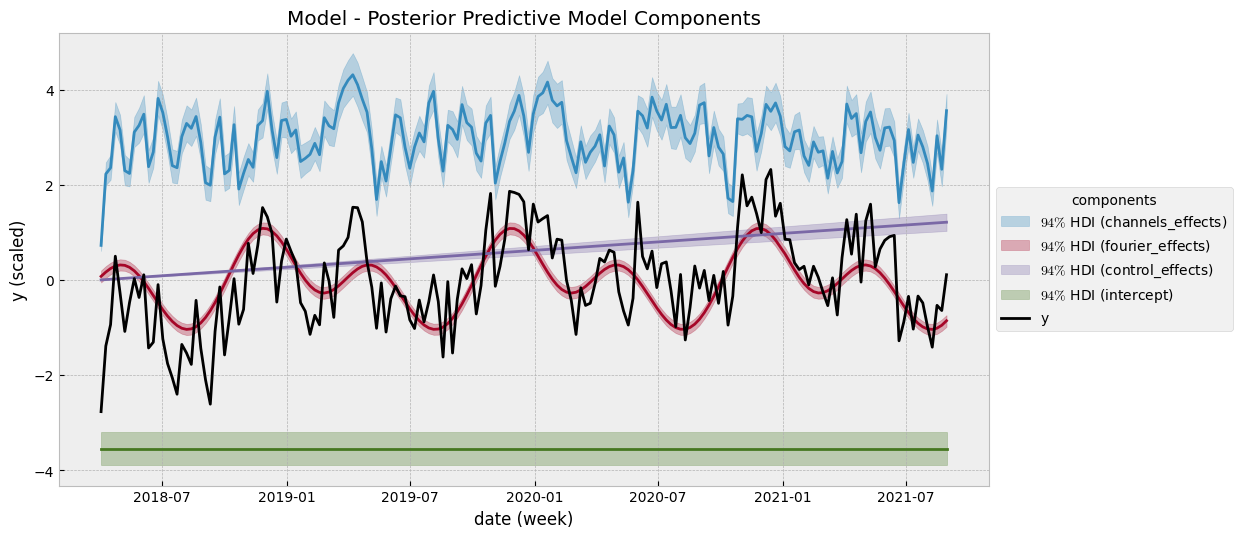

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))

for i, var_effect in enumerate(
    ["channels_effects", "fourier_effects", "control_effects"]
):
    ax.fill_between(
        x=date_week,
        y1=model_hdi[var_effect][:, 0],
        y2=model_hdi[var_effect][:, 1],
        color=f"C{i}",
        alpha=0.3,
        label=f"$94\%$ HDI ({var_effect})",
    )
    sns.lineplot(
        x=date_week,
        y=idata.posterior[var_effect].stack(sample=("chain", "draw")).mean(axis=1),
        color=f"C{i}",
    )

intercept_hdi = np.repeat(
    a=model_hdi["intercept"].to_numpy()[None, ...], repeats=n_obs, axis=0
)
sns.lineplot(
    x=date_week,
    y=idata.posterior["intercept"].stack(sample=("chain", "draw")).to_numpy().mean(),
    color=f"C{i + 1}",
)
ax.fill_between(
    x=date_week,
    y1=intercept_hdi[:, 0],
    y2=intercept_hdi[:, 1],
    color=f"C{i + 1}",
    alpha=0.3,
    label="$94\%$ HDI (intercept)",
)
sns.lineplot(x=date_week, y=scaled_y, color="black", alpha=1.0, label=target, ax=ax)
ax.legend(title="components", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(
    title="Model - Posterior Predictive Model Components",
    xlabel="date (week)",
    ylabel=f"{target} (scaled)",
);

### 9. Adstock & Saturation Curves

In [23]:
trace_posterior_stack = idata.posterior.stack(sample=("chain", "draw"))

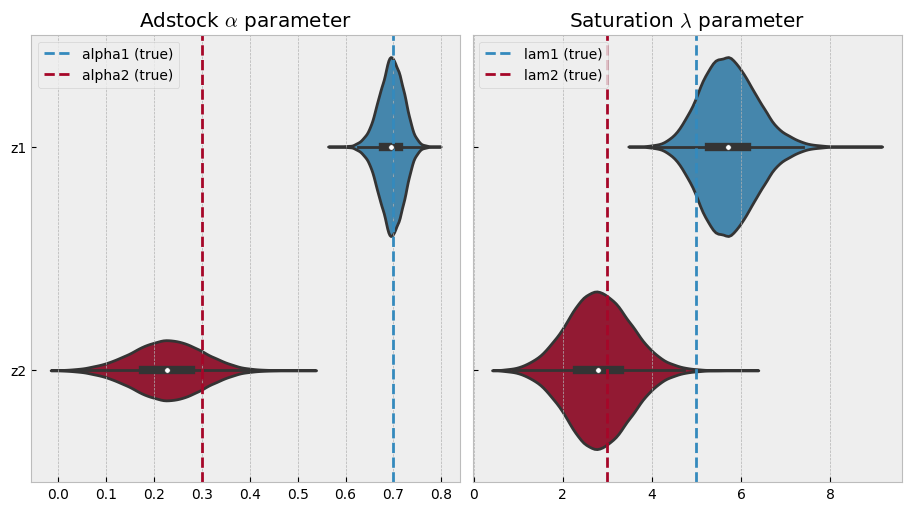

In [24]:
fig, ax = plt.subplots(
    ncols=2, nrows=1, figsize=(9, 5), sharey=True, layout="constrained"
)
sns.violinplot(
    data=pd.DataFrame(
        data=trace_posterior_stack["alpha"].to_numpy().T, columns=channels
    ),
    orient="h",
    ax=ax[0],
)
ax[0].axvline(x=alpha1, color="C0", linestyle="--", label="alpha1 (true)")
ax[0].axvline(x=alpha2, color="C1", linestyle="--", label="alpha2 (true)")
ax[0].legend(loc="upper left")
ax[0].set(title="Adstock $\\alpha$ parameter")
sns.violinplot(
    data=pd.DataFrame(data=trace_posterior_stack["lam"].to_numpy().T, columns=channels),
    orient="h",
    ax=ax[1],
)
ax[1].axvline(x=lam1, color="C0", linestyle="--", label="lam1 (true)")
ax[1].axvline(x=lam2, color="C1", linestyle="--", label="lam2 (true)")
ax[1].legend(loc="upper left")
ax[1].set(title="Saturation $\lambda$ parameter");

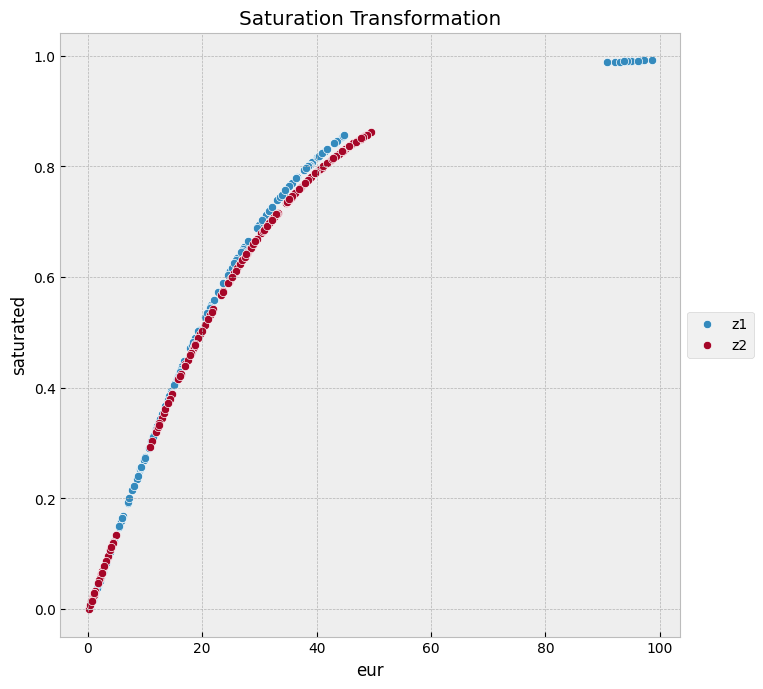

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))

for i, channel in enumerate(channels):
    sns.scatterplot(
        x=df[channel],
        y=trace_posterior_stack["channels_saturated"].mean(axis=2)[:, i],
        color=f"C{i}",
        label=f"{channel}",
        ax=ax,
    )
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(
    title=f"Saturation Transformation",
    xlabel="eur",
    ylabel="saturated",
);

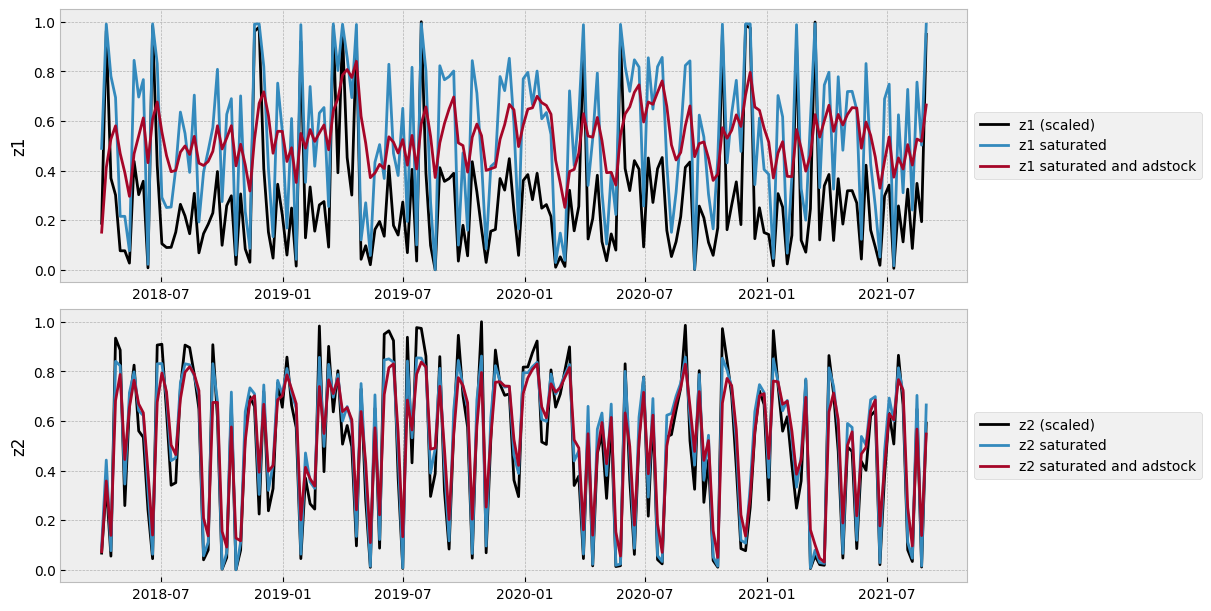

In [26]:
fig, axes = plt.subplots(
    nrows=n_channels,
    ncols=1,
    sharex=False,
    sharey=False,
    figsize=(12, n_channels * 3),
    layout="constrained",
)

for i, channel in enumerate(channels):
    ax = axes[i]
    sns.lineplot(
        x=date_week,
        y=scaled_channels_df[channel],
        color="black",
        label=f"{channel} (scaled)",
        ax=ax,
    )
    sns.lineplot(
        x=date_week,
        y=trace_posterior_stack["channels_saturated"].mean(axis=2)[:, i],
        color="C0",
        label=f"{channel} saturated",
        ax=ax,
    )
    sns.lineplot(
        x=date_week,
        y=trace_posterior_stack["channels_saturated_adstock"].mean(axis=2)[:, i],
        color="C1",
        label=f"{channel} saturated and adstock",
        ax=ax,
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [27]:
beta_inverse_transform = trace_posterior_stack["beta"] * endog_scaler.scale_[0]

channel_effect_original_scale = (
    beta_inverse_transform
    * trace_posterior_stack["channels_saturated_adstock"]
)

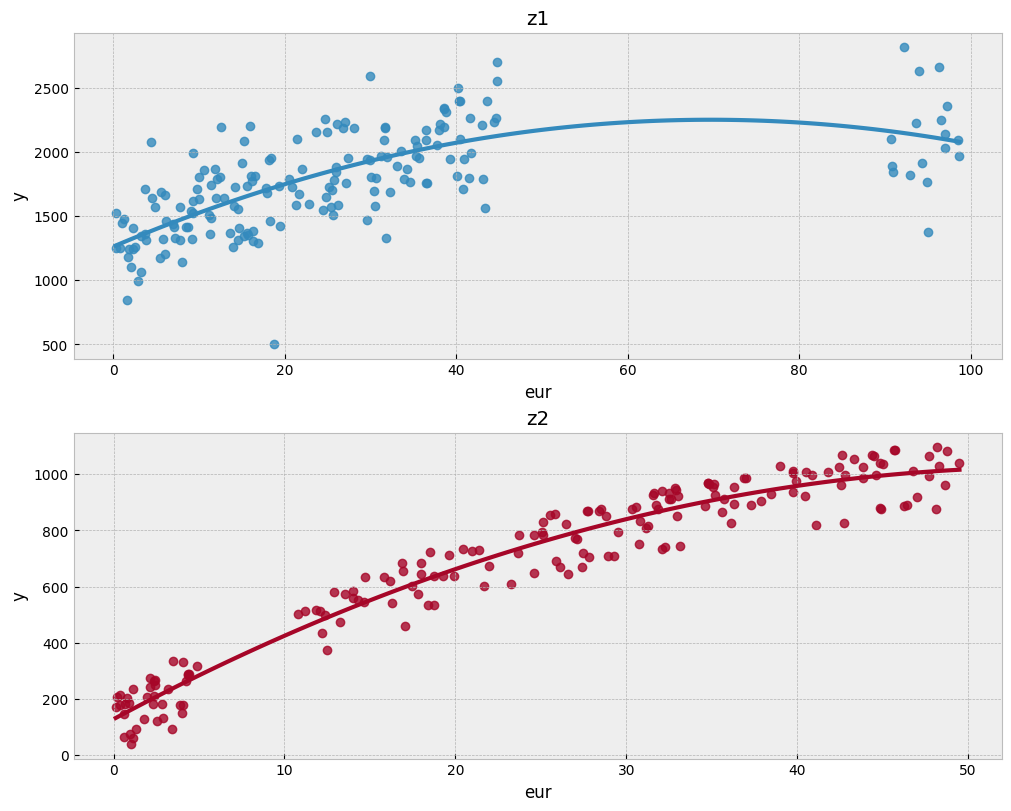

In [28]:
fig, axes = plt.subplots(
    nrows=n_channels,
    ncols=1,
    sharex=False,
    sharey=False,
    figsize=(10, n_channels * 4),
    layout="constrained",
)

for i, channel in enumerate(channels):
    ax = axes[i]
    sns.regplot(
        x=channels_df.to_numpy()[:, i],
        y=channel_effect_original_scale[i, :, :].mean(axis=0),
        color=f"C{i}",
        order=2,
        # lowess=True,
        ci=None,
        ax=ax,
    )
    ax.set(title=f"{channel}", xlabel="eur", ylabel=target)

In [29]:
channel_effect_original_scale_hdi = az.hdi(
    ary=idata.posterior["beta"].expand_dims({"date_week": n_obs}, axis=2)
    * endog_scaler.scale_[0]
    * idata.posterior["channels_saturated_adstock"]
)

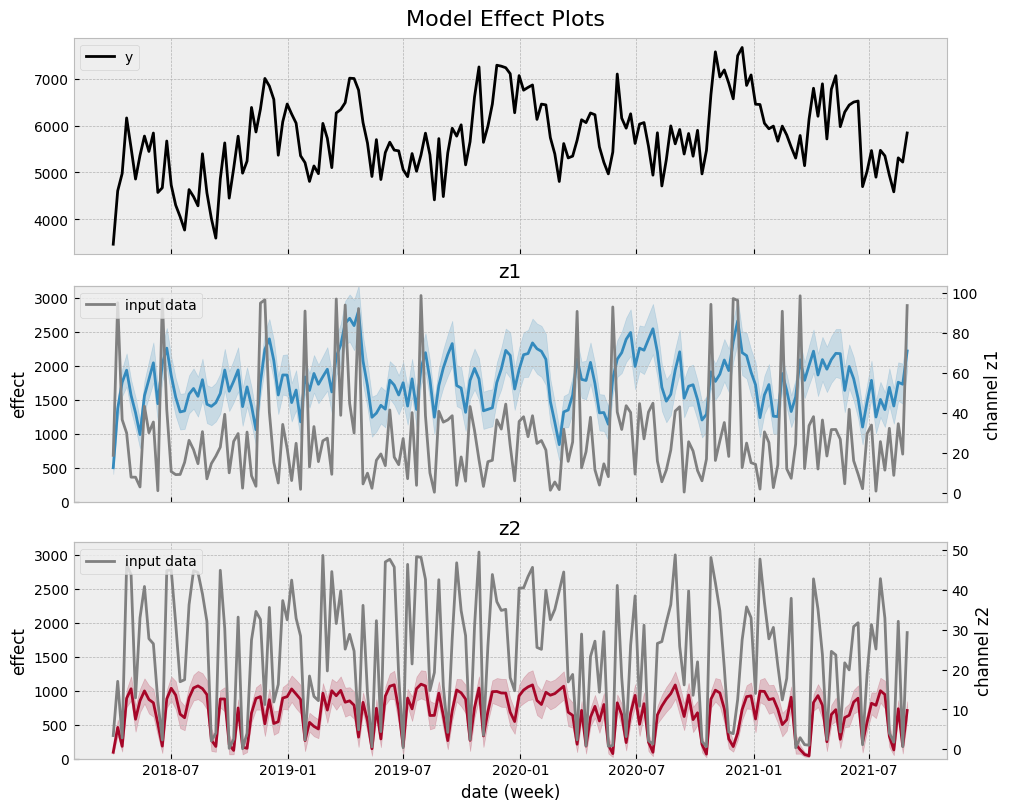

In [30]:
fig, axes = plt.subplots(
    nrows=n_channels + 1,
    ncols=1,
    sharex=True,
    sharey=False,
    figsize=(10, n_channels * 4),
    layout="constrained",
)

y_max = channel_effect_original_scale_hdi.x.max()

sns.lineplot(
    x=date_week,
    y=y,
    color="black",
    label=target,
    ax=axes[0],
)
axes[0].legend(loc="upper left")

for i, channel in enumerate(channels):
    ax = axes[i + 1]
    sns.lineplot(
        x=date_week,
        y=channel_effect_original_scale[i, :, :].mean(axis=0),
        color=f"C{i}",
        ci=None,
        ax=ax,
    )
    ax.fill_between(
        x=date_week,
        y1=channel_effect_original_scale_hdi["x"][:, i, 0],
        y2=channel_effect_original_scale_hdi["x"][:, i, 1],
        color=f"C{i}",
        alpha=0.2,
        label=f"$94\%$ HDI ({channel})",
    )

    ax_twin = ax.twinx()
    sns.lineplot(
        x=date_week,
        y=channels_df[channel],
        color="gray",
        label="input data",
        ax=ax_twin,
    )
    ax_twin.grid(None)
    ax_twin.set(xlabel=None, ylabel=f"channel {channel}")
    ax_twin.legend(loc="upper left")
    ax.set(title=f"{channel}", xlabel="date (week)", ylabel="effect", ylim=(0, y_max))

fig.suptitle("Model Effect Plots", fontsize=16);